### Installations and Imports

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib

In [2]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...


In [3]:
!cd yolov5 & pip install -r requirements.txt

DEPRECATION: Loading egg at c:\users\anton\python_projects\nicholas_renotte\nick_venv\lib\site-packages\object_detection-0.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\anton\python_projects\nicholas_renotte\nick_venv\lib\site-packages\pyparsing-2.4.7-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\anton\python_projects\nicholas_renotte\nick_venv\lib\site-packages\sacrebleu-2.2.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [4]:
import mediapipe as mp

In [5]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
import time


### Load the models

In [6]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in C:\Users\Anton/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-5-30 Python-3.12.2 torch-2.3.0+cpu CPU

100%|█████████████████████████████████████████████████████████████████████████████| 14.1M/14.1M [00:06<00:00, 2.47MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


#### Keypoints using MP Holistic

In [7]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [8]:
# Function to draw landmarks with default styles
def draw_landmarks(image, results):
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)


In [9]:
# Function to draw landmarks with custom styles
def draw_styled_landmarks(image, results):
    # Draw face connections
    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
            mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
            mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1)
        )
    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2)
        )
    # Draw left hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2)
        )
    # Draw right hand connections
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
        )


In [10]:
# Function to process the image using mediapipe detection
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert the image color to RGB
    image.flags.writeable = False                   # Image is no longer writeable
    results = model.process(image)                  # Make prediction
    image.flags.writeable = True                    # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert the image color back to BGR
    return image, results

#### Object detection of images

In [11]:
img = 'https://upload.wikimedia.org/wikipedia/en/c/cb/Monkey_D_Luffy.png'

In [12]:
# Get detections from the model
results = model(img)
results.print()

image 1/1: 426x220 1 person, 1 tennis racket
Speed: 1575.8ms pre-process, 296.6ms inference, 14.2ms NMS per image at shape (1, 3, 640, 352)


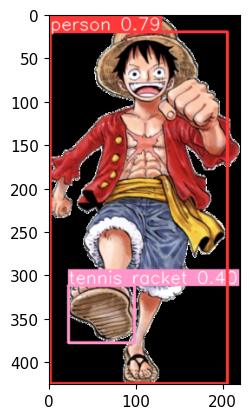

In [13]:
#Plot images with the detections
%matplotlib inline 
plt.imshow(np.squeeze(results.render()))
plt.show()

#### Real time detections using yolo v5

#### Press Q to exit

In [14]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Make detections 
    results = model(frame)
    
    cv2.imshow('YOLO', np.squeeze(results.render()))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

#### Real time detections using mediapipe

#### Press Q to exit

In [15]:
# Initialize webcam
cap = cv2.VideoCapture(0)

# Set up the holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        if not ret:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw styled landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()